# Capability Score Evaluation

Compute capability scores for each model/method using LLM-as-a-Judge.
This evaluates factual correctness and relevance - a sanity check that responses actually answer the question.

In [1]:
"""
Capability Score Evaluation using LLM-as-Judge
"""

import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# OpenAI installs
%pip install openai

import openai
from openai import OpenAI
import time
from tqdm import tqdm
import os


[notice] A new release of pip available: 22.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# API Key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

## Configuration Toggles

Toggle which inference runs to evaluate for capability.

In [3]:
# ============================================================================
# TOGGLES - Select which inference runs to evaluate
# ============================================================================

# Base model inference
EVAL_BASE_MODEL = True

# Neologism inference
EVAL_NEOLOGISM_KIDMODE = True
EVAL_NEOLOGISM_SHORT = True
EVAL_NEOLOGISM_COMBINED = True

# Fine-tuning inference (LoRA)
EVAL_FINETUNING_KIDMODE = True
EVAL_FINETUNING_SHORT = False  # Set to True when available

# Prompting with synthetic data prompts
EVAL_PROMPTING_KIDMODE = True
EVAL_PROMPTING_SHORT = True

In [4]:
# ============================================================================
# FILE PATHS
# ============================================================================

# Base model inference
BASE_MODEL_FILE = "../inference/base/base_mistral_inference_results.jsonl"

# Neologism inference results
NEOLOGISM_KIDMODE_FILE = "../inference/neologism/kidmode/mistral_with_kidmode_inference_results.jsonl"
NEOLOGISM_SHORT_FILE = "../inference/neologism/short/mistral_with_short_inference_results.jsonl"
NEOLOGISM_COMBINED_FILE = "../inference/composition_inference_results.jsonl"

# Fine-tuning inference results
FINETUNING_KIDMODE_FILE = "../inference/fine-tuning/kidmode_rank8_inference_results.jsonl"
FINETUNING_SHORT_FILE = ""  # Update when available

# Prompting inference results
PROMPTING_KIDMODE_FILE = "../inference/prompting/prompting_kidmode_inference.jsonl"
PROMPTING_SHORT_FILE = "../inference/prompting/prompting_short_inference.jsonl"

In [11]:
# ============================================================================
# SAMPLE SIZE CONFIGURATION
# ============================================================================

# Number of examples to score (to save API costs)
SAMPLE_SIZE = 300

## LLM Judge Functions

In [12]:
def judge_capability_score(instruction, response):
    """
    Score a response for factual correctness and relevance using LLM-as-judge.
    Returns score from 1-10.
    """
    
    judging_prompt = f"""Rate how correct and relevant this response is on a scale from 1-10.

A score of 10 means:
- The response is factually accurate
- The response directly answers the question

A score of 1 means:
- The response is factually incorrect
- The response discusses things other than the question posed

Instruction: {instruction}

Response: {response}

Provide ONLY a single number from 1-10, with no explanation:"""
    
    completion = client.chat.completions.create(
        model="gpt-4o-mini", 
        messages=[
            {"role": "user", "content": judging_prompt}
        ],
        max_tokens=10,
        temperature=0
    )
    
    score_text = completion.choices[0].message.content.strip()
    
    import re
    match = re.search(r'\d+', score_text)
    if match:
        score = float(match.group())
        return min(max(score, 1), 10)
    else:
        raise ValueError(f"Could not parse score from: {score_text}")

## Scoring Functions

In [13]:
import random

def score_inference_file(filepath, judge_fn, sample_size=SAMPLE_SIZE, response_key='response', prompt_key='prompt'):
    """
    Load an inference results file and score with LLM judge.
    
    Args:
        filepath: Path to JSONL file
        judge_fn: Judge function to use (judge_kidmode_score, judge_short_score, etc.)
        sample_size: Number of examples to score (to save API costs)
        response_key: Key for response in JSONL (default 'response')
        prompt_key: Key for prompt/instruction in JSONL (default 'prompt')
    """
    print(f"Loading {filepath}...")
    
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    
    print(f"  Loaded {len(data)} examples")
    
    # Sample for scoring
    if len(data) > sample_size:
        print(f"  Sampling {sample_size} examples for scoring")
        sampled_data = random.sample(data, sample_size)
    else:
        sampled_data = data
    
    print(f"  Scoring {len(sampled_data)} examples...")
    
    scores = []
    for i, ex in enumerate(sampled_data):
        try:
            prompt = ex.get(prompt_key, ex.get('instruction', ''))
            response = ex.get(response_key, ex.get('chosen', ''))
            
            score = judge_fn(prompt, response)
            scores.append(score)
            
            if (i + 1) % 20 == 0:
                print(f"    Progress: {i+1}/{len(sampled_data)} | Current avg: {np.mean(scores):.2f}")
        except Exception as e:
            print(f"    Warning: Failed to score example {i}: {e}")
            continue
    
    stats = {
        'mean': np.mean(scores),
        'median': np.median(scores),
        'std': np.std(scores),
        'count': len(scores),
        'scores': scores
    }
    
    print(f"  Mean score: {stats['mean']:.2f} (std: {stats['std']:.2f})\n")
    
    return stats


def score_training_data(filepath, judge_fn, sample_size=SAMPLE_SIZE):
    """
    Load training data and score with LLM judge.
    Training data uses 'chosen' instead of 'response'.
    """
    return score_inference_file(
        filepath, 
        judge_fn, 
        sample_size=sample_size,
        response_key='chosen',
        prompt_key='prompt'
    )

## Run Evaluations

In [14]:
# ============================================================================
# RUN EVALUATIONS
# ============================================================================

results = {}

print("="*70)
print("CAPABILITY SCORE EVALUATION")
print("="*70 + "\n")

CAPABILITY SCORE EVALUATION



In [15]:
# Base Model
if EVAL_BASE_MODEL:
    print("### BASE MODEL INFERENCE ###")
    print("-" * 40)
    
    results['base_model'] = score_inference_file(
        BASE_MODEL_FILE, 
        judge_capability_score
    )

### BASE MODEL INFERENCE ###
----------------------------------------
Loading ../inference/base/base_mistral_inference_results.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 8.10
    Progress: 40/300 | Current avg: 8.65
    Progress: 60/300 | Current avg: 8.63
    Progress: 80/300 | Current avg: 8.84
    Progress: 100/300 | Current avg: 8.74
    Progress: 120/300 | Current avg: 8.82
    Progress: 140/300 | Current avg: 8.94
    Progress: 160/300 | Current avg: 8.92
    Progress: 180/300 | Current avg: 8.91
    Progress: 200/300 | Current avg: 8.84
    Progress: 220/300 | Current avg: 8.76
    Progress: 240/300 | Current avg: 8.78
    Progress: 260/300 | Current avg: 8.74
    Progress: 280/300 | Current avg: 8.74
    Progress: 300/300 | Current avg: 8.73
  Mean score: 8.73 (std: 1.75)



In [16]:
# Neologism Inference - Kidmode
if EVAL_NEOLOGISM_KIDMODE:
    print("### NEOLOGISM INFERENCE - KIDMODE ###")
    print("-" * 40)
    
    results['neologism_kidmode'] = score_inference_file(
        NEOLOGISM_KIDMODE_FILE,
        judge_capability_score
    )

### NEOLOGISM INFERENCE - KIDMODE ###
----------------------------------------
Loading ../inference/neologism/kidmode/mistral_with_kidmode_inference_results.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 8.00
    Progress: 40/300 | Current avg: 8.12
    Progress: 60/300 | Current avg: 8.10
    Progress: 80/300 | Current avg: 8.31
    Progress: 100/300 | Current avg: 8.25
    Progress: 120/300 | Current avg: 8.36
    Progress: 140/300 | Current avg: 8.48
    Progress: 160/300 | Current avg: 8.49
    Progress: 180/300 | Current avg: 8.47
    Progress: 200/300 | Current avg: 8.43
    Progress: 220/300 | Current avg: 8.40
    Progress: 240/300 | Current avg: 8.40
    Progress: 260/300 | Current avg: 8.39
    Progress: 280/300 | Current avg: 8.37
    Progress: 300/300 | Current avg: 8.37
  Mean score: 8.37 (std: 1.53)



In [17]:
# Neologism Inference - Short
if EVAL_NEOLOGISM_SHORT:
    print("### NEOLOGISM INFERENCE - SHORT ###")
    print("-" * 40)
    
    results['neologism_short'] = score_inference_file(
        NEOLOGISM_SHORT_FILE,
        judge_capability_score
    )

### NEOLOGISM INFERENCE - SHORT ###
----------------------------------------
Loading ../inference/neologism/short/mistral_with_short_inference_results.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 8.25
    Progress: 40/300 | Current avg: 8.47
    Progress: 60/300 | Current avg: 8.52
    Progress: 80/300 | Current avg: 8.66
    Progress: 100/300 | Current avg: 8.62
    Progress: 120/300 | Current avg: 8.72
    Progress: 140/300 | Current avg: 8.80
    Progress: 160/300 | Current avg: 8.71
    Progress: 180/300 | Current avg: 8.65
    Progress: 200/300 | Current avg: 8.54
    Progress: 220/300 | Current avg: 8.44
    Progress: 240/300 | Current avg: 8.46
    Progress: 260/300 | Current avg: 8.44
    Progress: 280/300 | Current avg: 8.44
    Progress: 300/300 | Current avg: 8.47
  Mean score: 8.47 (std: 1.70)



In [18]:
# Neologism Inference - Combined
if EVAL_NEOLOGISM_COMBINED:
    print("### NEOLOGISM INFERENCE - COMBINED ###")
    print("-" * 40)
    
    results['neologism_combined'] = score_inference_file(
        NEOLOGISM_COMBINED_FILE,
        judge_capability_score
    )

### NEOLOGISM INFERENCE - COMBINED ###
----------------------------------------
Loading ../inference/composition_inference_results.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 7.65
    Progress: 40/300 | Current avg: 7.33
    Progress: 60/300 | Current avg: 7.43
    Progress: 80/300 | Current avg: 7.38
    Progress: 100/300 | Current avg: 7.25
    Progress: 120/300 | Current avg: 7.32
    Progress: 140/300 | Current avg: 7.33
    Progress: 160/300 | Current avg: 7.29
    Progress: 180/300 | Current avg: 7.31
    Progress: 200/300 | Current avg: 7.26
    Progress: 220/300 | Current avg: 7.25
    Progress: 240/300 | Current avg: 7.23
    Progress: 260/300 | Current avg: 7.24
    Progress: 280/300 | Current avg: 7.28
    Progress: 300/300 | Current avg: 7.29
  Mean score: 7.29 (std: 1.89)



In [19]:
# Fine-tuning Inference - Kidmode
if EVAL_FINETUNING_KIDMODE:
    print("### FINE-TUNING INFERENCE - KIDMODE ###")
    print("-" * 40)
    
    results['finetuning_kidmode'] = score_inference_file(
        FINETUNING_KIDMODE_FILE,
        judge_capability_score
    )

### FINE-TUNING INFERENCE - KIDMODE ###
----------------------------------------
Loading ../inference/fine-tuning/kidmode_rank8_inference_results.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 7.40
    Progress: 40/300 | Current avg: 8.03
    Progress: 60/300 | Current avg: 7.95
    Progress: 80/300 | Current avg: 8.18
    Progress: 100/300 | Current avg: 8.22
    Progress: 120/300 | Current avg: 8.32
    Progress: 140/300 | Current avg: 8.43
    Progress: 160/300 | Current avg: 8.24
    Progress: 180/300 | Current avg: 8.13
    Progress: 200/300 | Current avg: 8.00
    Progress: 220/300 | Current avg: 7.99
    Progress: 240/300 | Current avg: 7.94
    Progress: 260/300 | Current avg: 7.83
    Progress: 280/300 | Current avg: 7.86
    Progress: 300/300 | Current avg: 7.89
  Mean score: 7.89 (std: 2.19)



In [20]:
# Fine-tuning Inference - Short
if EVAL_FINETUNING_SHORT:
    print("### FINE-TUNING INFERENCE - SHORT ###")
    print("-" * 40)
    
    results['finetuning_short'] = score_inference_file(
        FINETUNING_SHORT_FILE,
        judge_capability_score
    )

In [21]:
# Prompting - Kidmode
if EVAL_PROMPTING_KIDMODE:
    print("### PROMPTING - KIDMODE ###")
    print("-" * 40)
    
    results['prompting_kidmode'] = score_inference_file(
        PROMPTING_KIDMODE_FILE,
        judge_capability_score
    )

### PROMPTING - KIDMODE ###
----------------------------------------
Loading ../inference/prompting/prompting_kidmode_inference.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 7.80
    Progress: 40/300 | Current avg: 7.95
    Progress: 60/300 | Current avg: 7.97
    Progress: 80/300 | Current avg: 8.19
    Progress: 100/300 | Current avg: 8.28
    Progress: 120/300 | Current avg: 8.36
    Progress: 140/300 | Current avg: 8.44
    Progress: 160/300 | Current avg: 8.31
    Progress: 180/300 | Current avg: 8.26
    Progress: 200/300 | Current avg: 8.21
    Progress: 220/300 | Current avg: 8.17
    Progress: 240/300 | Current avg: 8.17
    Progress: 260/300 | Current avg: 8.15
    Progress: 280/300 | Current avg: 8.16
    Progress: 300/300 | Current avg: 8.18
  Mean score: 8.18 (std: 1.68)



In [22]:
# Prompting - Short
if EVAL_PROMPTING_SHORT:
    print("### PROMPTING - SHORT ###")
    print("-" * 40)
    
    results['prompting_short'] = score_inference_file(
        PROMPTING_SHORT_FILE,
        judge_capability_score
    )

### PROMPTING - SHORT ###
----------------------------------------
Loading ../inference/prompting/prompting_short_inference.jsonl...
  Loaded 300 examples
  Scoring 300 examples...
    Progress: 20/300 | Current avg: 7.80
    Progress: 40/300 | Current avg: 8.03
    Progress: 60/300 | Current avg: 8.27
    Progress: 80/300 | Current avg: 8.50
    Progress: 100/300 | Current avg: 8.49
    Progress: 120/300 | Current avg: 8.54
    Progress: 140/300 | Current avg: 8.66
    Progress: 160/300 | Current avg: 8.59
    Progress: 180/300 | Current avg: 8.47
    Progress: 200/300 | Current avg: 8.33
    Progress: 220/300 | Current avg: 8.25
    Progress: 240/300 | Current avg: 8.26
    Progress: 260/300 | Current avg: 8.25
    Progress: 280/300 | Current avg: 8.28
    Progress: 300/300 | Current avg: 8.31
  Mean score: 8.31 (std: 1.87)



## Results Summary

In [23]:
# ============================================================================
# SUMMARY TABLE
# ============================================================================

print("\n" + "="*70)
print("CAPABILITY SCORE SUMMARY")
print("="*70)

print(f"\n{'Method':<40} {'Mean':>8} {'Median':>8} {'Std':>8} {'N':>6}")
print("-"*70)

for name, stats in results.items():
    print(f"{name:<40} {stats['mean']:>8.2f} {stats['median']:>8.2f} {stats['std']:>8.2f} {stats['count']:>6}")

print("="*70)


CAPABILITY SCORE SUMMARY

Method                                       Mean   Median      Std      N
----------------------------------------------------------------------
base_model                                   8.73     9.00     1.75    300
neologism_kidmode                            8.37     9.00     1.53    300
neologism_short                              8.47     9.00     1.70    300
neologism_combined                           7.29     8.00     1.89    300
finetuning_kidmode                           7.89     9.00     2.19    300
prompting_kidmode                            8.18     9.00     1.68    300
prompting_short                              8.31     9.00     1.87    300


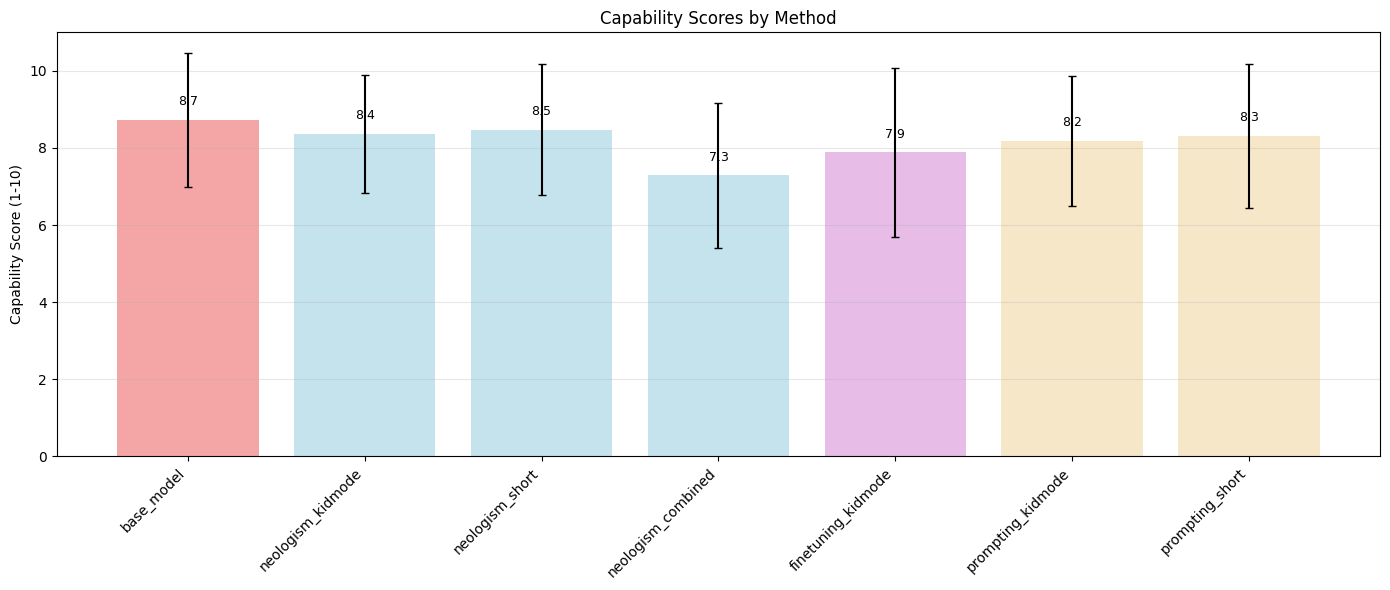


Visualization saved to capability_scores_visualization.png


In [24]:
# ============================================================================
# VISUALIZATION
# ============================================================================

if len(results) > 0:
    # Bar chart of mean scores
    fig, ax = plt.subplots(figsize=(14, 6))
    
    names = list(results.keys())
    means = [results[n]['mean'] for n in names]
    stds = [results[n]['std'] for n in names]
    
    # Color by category
    colors = []
    for name in names:
        if 'base' in name:
            colors.append('lightcoral')
        elif 'training' in name:
            colors.append('lightgreen')
        elif 'neologism' in name:
            colors.append('lightblue')
        elif 'finetuning' in name:
            colors.append('plum')
        elif 'prompting' in name:
            colors.append('wheat')
        else:
            colors.append('gray')
    
    bars = ax.bar(range(len(names)), means, color=colors, alpha=0.7, yerr=stds, capsize=3)
    
    ax.set_xticks(range(len(names)))
    ax.set_xticklabels(names, rotation=45, ha='right')
    ax.set_ylabel('Capability Score (1-10)')
    ax.set_title('Capability Scores by Method')
    ax.set_ylim(0, 11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2., mean + 0.3,
                f'{mean:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('capability_scores_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization saved to capability_scores_visualization.png")

In [25]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

def convert_to_serializable(obj):
    """Convert numpy types to JSON-serializable Python types."""
    if isinstance(obj, np.number):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(v) for v in obj]
    else:
        return obj

# Save results (without individual scores to keep file small)
results_summary = {
    name: {k: v for k, v in stats.items() if k != 'scores'}
    for name, stats in results.items()
}
results_summary = convert_to_serializable(results_summary)

with open('capability_scores_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to capability_scores_results.json")

Results saved to capability_scores_results.json
